**Ход работы над проектом:**


*   Работа над идеей 
*   Выбор API для получения данных о баскетбольных площадках Москвы 
*   Реализация нужного функционала для выкачивания данных
*   Работа с полученным данными
*   Создание telegram-бота
*   Реализация API-запросов для нахожения расстояний от пользователя до площадок



# Работа над идеей

Как любитель баскетбола, я крайне часто сталкиваюсь с потребностью найти игровую площадку. Конечно, есть онлайн-карты, но на моем телефоне они работают достаточно медленно, как и у многих моих друзей. Телеграм боты - вещь крайне актуальная и быстродейственная, поэтому я придумал следующей проект: бот, который кидает пользователю ближайшие к нему баскетбольные площадки.


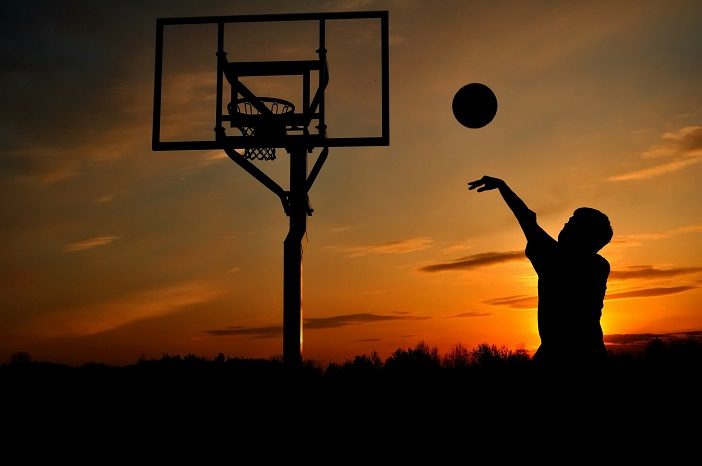


Теперь необходимо придумать архитектуру проекта. Я решил попробовать следующий вариант: все необходимые данные изначально загрузить к себе на компьютер, обработать их должным образом, а дальше написать телеграм бота. Когда он запущен на сервере и получает запрос пользователя, он перебирает все баскетбольные площадки в сохраненном датасете, и скидывает пользователю ближайшие к нему. Для подсчета расстояний можно так же воспользоваться каким-то сервисом. Конечно, можно при каждом запроса бота искать ближайшие площадки через API. Но, на мой взгляд, гораздо легче сохранить к себе на компьютер имеющиеся данные - ведь их немного, и, например, обновлять раз в месяц. Это и быстрее, и надежнее, а работать с API все равно придется.

# Выбор API

Здесь надо отталкиваться от нескольких параметров:


*   Удобство в использовании
*   Качественная документация
*   Возможность бесплатного использования в личном учебном проекте

Изначально, я рассматривар три варианта - 2ГИС, Яндекс.Карты и GoogleMaps. 
В первом случае необходимо оформлять специальную заявку - уже не подходит, непонятно, когда ее рассмотрят. 
Яндекс.Карты - конкретнее, мне необходим сервис Поиск по организациям. Это именно то, что происходит у пользователя, когда он пишет в картах текстовый запрос. Но в правилах видим следующее - "Результаты поиска нельзя сохранять, использовать без карты или размещать на карте другого поставщика." Досадно, ну да ладно.
Остаются GoogleMaps, которые и на лекции были использован. У них в правилах таких строгих мер нет. Единственное, надо быть очень аккуратным с количеством запросов. Конкретнее, мне был необходим PlacesApi: 
https://developers.google.com/maps/documentation/places/web-service/overview?hl=ru

Если коротко, то Google предоставляет 300 долларов на первые 3 месяца использования этого сервиса, а так же 200 долларов ежемесячно. То есть, за каждый запрос придется платить (пусть и небольшие деньги, но запросов можно сделать очень много, ведь ограничения на количество запросов в сутки нет, только на их количество в секунду), но на какую-то сумму можно их делать абсолютно бесплатно. Окей, будем следить за показателями счета и статистикой использования API.


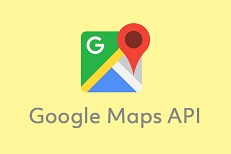






# Реализация запросов

Хотелось бы программно реализовывать поисковый запрос, например:

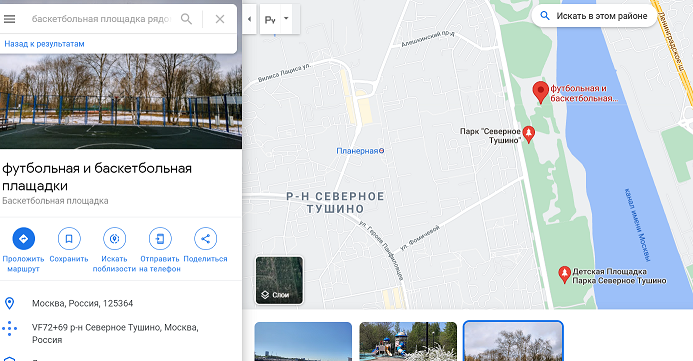

Открываем документацию, видим, что запросы вида TextSearch - то, что нам нужно. Необходимо лишь правильно сформулировать текст запроса, ну и получить API ключ. Создаем в Google новый проект, привязываем карту, активируем Places API. 

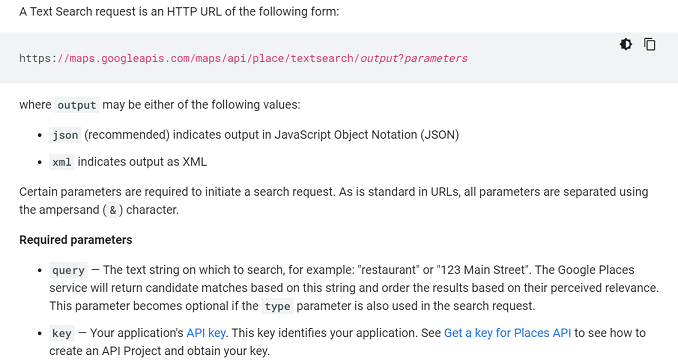

В ответе на данный запрос нас интересуют поля, отвечающие за название площадки, ее адрес и координаты.

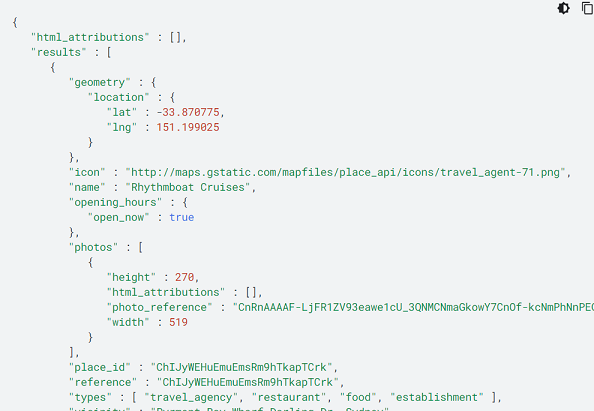


Так же хотелось бы кидать пользователю фотографию площадку. За это отвечает отдельный запрос Place Photos. Для него необходим сохранить photo_reference и photo_width, для всех площадок, у которых есть хотя бы 1 фотография в Google Maps, из ответа на Text Search запрос. Теперь надо реализовать программный интерфейс.

**Класс PlacesApi**

Мною был реализован класс PlacesApi для программной работы с GoogleMaps. Он содержит в себе:



*   конструктор, при инициализации объекта в поле key записывается API ключ из  файла с соответствующим именем
*   метод make_text_search_request, позволяющий сделать соответствующий API-запрос и возвращающий ответ на него
*   метод make_photo_search_request, позволяющий сделать соответствующий API-запрос и возвращающий ответ на него
*   static метод json_to_dict, удаляющий лишние поля в JSON-файле и возвращающий словарь с интересующими нас данными




Дальше сталкиваемся с небольшой проблемой. Запрос TextSearch возвращает до 60 объектов (вернее, до 20, но можно получить до 60, делая запрос на каждую следующую группу по 20) - а баскетбольных площадок в Москве явно больше. Мне пришла в голову следующая идея - сделать запросы отдельно про каждый из районов Москвы. 

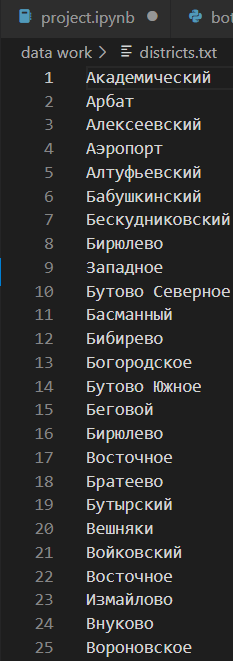

Ну, районы можно выкачать и вручную! Зато теперь знаю, что их в Москве 146. Отлично, теперь реализуем класс, который позволяет заполнить датасет с данными о баскетбольных площадок Москвы в фиксированных районах.

**Класс DataBuilder**

Класс содержит в себе:



*   static метод read_district, читающий из файла список районов
*   static метод create_dataframe, создающий датасет с фиксированными столбцами, делая запросы в соответствующие районы
*   static метод get_photos_from_dataframe, берующий из датасета данные о фото в GoogleMaps (photo_reference, photo_width) и делающий API запросы, скачивая все фото в нужную папку. 



# Работа с данными

Импортируем библиотеки для работы с данными, и написанный мною модуль для построения нужных нам данных из GoogleMaps.

In [ ]:
import pandas as pd 
import numpy as np 
from DataBuilder import DataBuilder
         

Создадим объект класса, реализующий необходимые нам методы.

In [ ]:

data_builder = DataBuilder()


Построим датафрейм с нужной нам информацией о баскетбольных площадках москвы. Передаем все необходимые столбцы и пути. 

In [ ]:
keys = ["name", "latitude", "longitude", "adress", "photo_id", "photo_width"]
basketball_data.create_dataframe(basketball_data.read_districts("districts.txt"), keys, "data/dataframe.csv")


Посмотрим, что получилось!

In [ ]:

pd.options.display.max_rows = 400 #чтобы можно было смотреть сразу на весь датасет
df = pd.read_csv("data/dataframe.csv", usecols = ["name", "latitude", "longitude", "adress", "photo_id", "photo_width"]) #оставляем только нужные столбцы, отсекая csv-индексацию
df.head()

,name,latitude,longitude,adress,photo_id,photo_width
0,Баскетбольная площадка,55.692279,37.596758,"Москва, Россия, 117449",NaN,NaN
1,Академический парк,55.691495,37.566863,"ул. Дмитрия Ульянова, 9Ас1, Москва, Россия, 11...",Aap_uEAS5vR6MTTqib1MbKuHwXMcvqi9sbsgj1pupsDe4M...,6016.0
2,Баскетбольная/футбольная коробка,55.695427,37.569923,"Москва, Россия, 117312",Aap_uEAA9iNe7oYPfR9Pzi9EuYvaPYuWw68oH5YUDTaspr...,4032.0
3,Большая волейбольно-баскетбольная площадка,55.666853,37.541255,"Почта, Москва, Россия, 117393",Aap_uEDEkpVZuobn6bMS_SDEIJWzzpvhnohPEQqhvJkv0D...,5504.0
4,Баскетбольная площадка,55.713873,37.608203,"Москва, Россия, 115419",NaN,NaN


Отлично, данные есть! Теперь поработаем с ними: удалим дубликаты (одна только знаменитая баскетбольная площадке на Рижской встречается 48 раз), удалим лишние объекты (тут у нас нашлись и отдел МВД, и клиника Медси).

In [ ]:
print(len(df.index))
df = pd.DataFrame.drop_duplicates(df, subset=["latitude", "longitude", "name", "adress"])
print(len(df.index))

2019
374


Приведем данные к одному регистру.

In [ ]:

for index, row in df.iterrows():
    df.loc[index, "name"] = row["name"].lower()
    df.loc[index, "adress"] = row["adress"].lower()

df.head()

,name,latitude,longitude,adress,photo_id,photo_width
0,баскетбольная площадка,55.692279,37.596758,"москва, россия, 117449",NaN,NaN
1,академический парк,55.691495,37.566863,"ул. дмитрия ульянова, 9ас1, москва, россия, 11...",Aap_uEAS5vR6MTTqib1MbKuHwXMcvqi9sbsgj1pupsDe4M...,6016.0
2,баскетбольная/футбольная коробка,55.695427,37.569923,"москва, россия, 117312",Aap_uEAA9iNe7oYPfR9Pzi9EuYvaPYuWw68oH5YUDTaspr...,4032.0
3,большая волейбольно-баскетбольная площадка,55.666853,37.541255,"почта, москва, россия, 117393",Aap_uEDEkpVZuobn6bMS_SDEIJWzzpvhnohPEQqhvJkv0D...,5504.0
4,баскетбольная площадка,55.713873,37.608203,"москва, россия, 115419",NaN,NaN


Удалим лишние объекты. Для этого сформируем список ключевых слов и удалим те строчки, в названии которых нет ни одного

In [ ]:
delete_rows = []
words = ["баскетбол", "мяч", "площадка", "nba", "ball", "jam", "спорт", "hall"]
for index, row in df.iterrows():
    flag = True
    for word in words:
        if word in df.loc[index, "name"]:
            flag = False
    if flag:
        delete_rows.append(index)
df = df.drop(delete_rows)
print(len(df.index))
df


170


,name,latitude,longitude,adress,photo_id,photo_width
0,баскетбольная площадка,55.692279,37.596758,"москва, россия, 117449",NaN,NaN
2,баскетбольная/футбольная коробка,55.695427,37.569923,"москва, россия, 117312",Aap_uEAA9iNe7oYPfR9Pzi9EuYvaPYuWw68oH5YUDTaspr...,4032.0
3,большая волейбольно-баскетбольная площадка,55.666853,37.541255,"почта, москва, россия, 117393",Aap_uEDEkpVZuobn6bMS_SDEIJWzzpvhnohPEQqhvJkv0D...,5504.0
4,баскетбольная площадка,55.713873,37.608203,"москва, россия, 115419",NaN,NaN
5,nba jam,55.658647,37.611774,"фруктовая ул., 9, москва, россия, 117556",Aap_uEBwiLIvlcEI6khXSM0bnYKAcGKIG7eQY4bSPbxq7N...,4160.0
6,баскетбольная площадка,55.663909,37.492203,"москва, россия, 119526",NaN,NaN
7,баскетбольная площадка,55.642480,37.514260,"ул. академика арцимовича, 7, москва, россия, 1...",Aap_uECWouLwQY2Vp-P4hWIq_G9kUKCoGEmVdNfzHArRHC...,4160.0
8,баскетбольная площадка,55.696581,37.642073,"автозаводская ул., 23 строение 94, москва, рос...",NaN,NaN
9,basketball court,55.669787,37.571737,"москва, россия, 117418",NaN,NaN
10,баскетбольная площадка,55.627984,37.523705,"ул. академика капицы, 14, москва, россия, 117647",NaN,NaN


Теперь осталось только 170 площадок! Грустно, что в Москве их так мало. Но, что вероятнее, в GoogleMaps просто не так много информации о них. Переделаем еще индексы для удобства.

In [ ]:
indeces = np.arange(170)
df.index = indeces
df

,name,latitude,longitude,adress,photo_id,photo_width
0,баскетбольная площадка,55.692279,37.596758,"москва, россия, 117449",NaN,NaN
1,баскетбольная/футбольная коробка,55.695427,37.569923,"москва, россия, 117312",Aap_uEAA9iNe7oYPfR9Pzi9EuYvaPYuWw68oH5YUDTaspr...,4032.0
2,большая волейбольно-баскетбольная площадка,55.666853,37.541255,"почта, москва, россия, 117393",Aap_uEDEkpVZuobn6bMS_SDEIJWzzpvhnohPEQqhvJkv0D...,5504.0
3,баскетбольная площадка,55.713873,37.608203,"москва, россия, 115419",NaN,NaN
4,nba jam,55.658647,37.611774,"фруктовая ул., 9, москва, россия, 117556",Aap_uEBwiLIvlcEI6khXSM0bnYKAcGKIG7eQY4bSPbxq7N...,4160.0
5,баскетбольная площадка,55.663909,37.492203,"москва, россия, 119526",NaN,NaN
6,баскетбольная площадка,55.642480,37.514260,"ул. академика арцимовича, 7, москва, россия, 1...",Aap_uECWouLwQY2Vp-P4hWIq_G9kUKCoGEmVdNfzHArRHC...,4160.0
7,баскетбольная площадка,55.696581,37.642073,"автозаводская ул., 23 строение 94, москва, рос...",NaN,NaN
8,basketball court,55.669787,37.571737,"москва, россия, 117418",NaN,NaN
9,баскетбольная площадка,55.627984,37.523705,"ул. академика капицы, 14, москва, россия, 117647",NaN,NaN


Видим, что есть еще некоторые лишние ячейки (смотровая площадка, хоккейная площадка)! Удалим их.

In [ ]:
df = df.drop(167)
df = df.drop([80, 87, 164])
df = df.drop(156)
df = df.drop(136)
df = df.drop(138)
df = df.drop(163)

In [ ]:
print(len(df.index))


162


И в последний раз приведем индексы!

In [ ]:
indeces = np.arange(162)
df.index = indeces

Приведем ширину картинки к типу int для красоты.

In [ ]:
df = df.fillna("0")
for index, row in df.iterrows():
    df.loc[index, "photo_width"] = int(df.loc[index, "photo_width"])
df.head()

,name,latitude,longitude,adress,photo_id,photo_width
0,баскетбольная площадка,55.692279,37.596758,"москва, россия, 117449",0,0
1,баскетбольная/футбольная коробка,55.695427,37.569923,"москва, россия, 117312",Aap_uEAA9iNe7oYPfR9Pzi9EuYvaPYuWw68oH5YUDTaspr...,4032
2,большая волейбольно-баскетбольная площадка,55.666853,37.541255,"почта, москва, россия, 117393",Aap_uEDEkpVZuobn6bMS_SDEIJWzzpvhnohPEQqhvJkv0D...,5504
3,баскетбольная площадка,55.713873,37.608203,"москва, россия, 115419",0,0
4,nba jam,55.658647,37.611774,"фруктовая ул., 9, москва, россия, 117556",Aap_uEBwiLIvlcEI6khXSM0bnYKAcGKIG7eQY4bSPbxq7N...,4160


Окей, работа с данными завершена. Можно сохранять датасет. 

In [ ]:
df.to_csv("data/database.csv", encoding="utf-8")

А теперь запустим метод, который скачает все фотографии для тех площадок, у которых они есть в GoogleMaps!

In [ ]:
basketball_data = BasketballData()
basketball_data.get_photos_from_dataframe("data/database.csv")

Получилось!

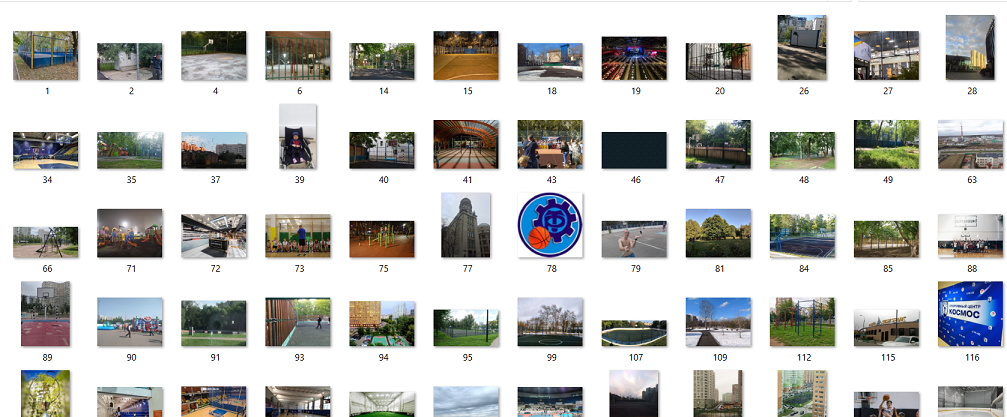

Конечно, фотографии не идеальны. Можно их вручную поудалять (всего несколько штук не являются фотками именно площадок), можно и не удалять - в конце концов, чем мой бот лучше GoogleMaps, откуда он и берет данные?

Самое главное, что работа с данными закончена! Можно переходить к созданию бота.

# Telegram Bot

Здесь все стандартно - получаем у BotFather в телеграме токен, кладем его в файлик, создаем объект класса TeleBot. Конечно, работаем с PyTelegramBotApi. Бот запускается одной строчкой (библиотечный метод polling). Необходимо лишь написать декораторы для требуемых функций-обработчиков, а именно:

Обработка текстового сообщения:


*  Если пользователь написал */start*, это стандартная команда для работы с ботами, написать ему: напиши /help
*  Если пользователь написал */help*, написать ему: напиши */get_courts*, в дальнейшем можно будет скидывать список возможных команд
*  В случае получения команды */get_courts* необходимо реализовать весь фактический функционал бота
   */get_courts* - скинуть ближайшие площадки


При получении команды */get_courts* бот отправляет пользователю кнопку, при нажатии на которую боту отправится его текущая геолокация. В принципе, геолокацию можно отправить и самостоятельно (причем любую), тогда бот точно так же отреагурирует отправкой площадок. 

И так, при получении геолокации запускается функция-обработчик. В ней бот обращается к датасету с информацией о площадках, выбирает оттуда ближайшие к геолокации, которую скинул пользователь, и скидывает информацию о них поочередно. Для этого используется класс FindPlaces и функции из файла distances. Изначально мною было решено отбирать те площадки, расстояния до которых в пути на машине не превосходит пяти минут (до таких можно сравнительно быстро добраться и пешком). Для этого, чтобы не производить API-запросы ко всему датасету, отбираются те площадки, до которых расстояние просто по прямой (как будто бы нет никаких препятствий) позволяет до них добраться в нужное время (для этого используются формулы рассчета расстояния между двумя точками на Земле и фиксированная скорость). Для этих площадок делаются API-запросы, и в случае удовлетворительного времени пути, информация о них скидывается пользователю.

# Расстояния

В проекте я решил использовать Спутник API - этот полностью свободный и бесплатный сервис я уже использовал раннее в работе, и могу сказать, что он работает не сильно хуже, чем GoogleMaps и Яндекс.Карты. Здесь все стандартно, необходимо просто задать в параметрах запроса долготу и ширину (для этого мы и сохраняли координаты площадок в датасет. Ну и для того чтобы отправлять пользователю локацию).


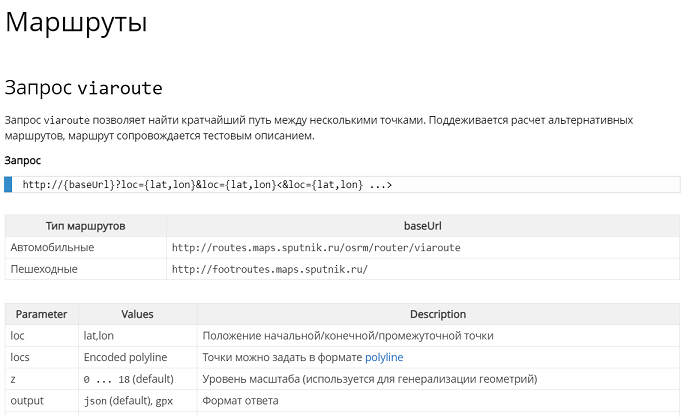